In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Defining the seasons and models used
seasons = ['2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07'] 
           
models = ['SVM']#,'Elastic Net','Random Forest','AdaBoost','Gradient Boosting','LGBM']

path = current_path = os.getcwd()
print(path)
# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/NBA-Modelo-MVP/Modelo MVP'

sep = r'/'

/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor


In [3]:
def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    advanced_stats = pd.DataFrame()
    standings = pd.DataFrame()

    for season in seasons:
        pergame = pd.read_csv(path_data+sep+'Dados'+sep+season+' Por Jogo.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Dados'+sep+season+' Total.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Dados'+sep+season+' Avançados.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Dados'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        
        
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season
        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanced_stats = pd.concat([advanced_stats,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)

    return per_game, totals, advanced_stats, standings


In [4]:
def treat_data(per_game, totals, advanced, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    advanced = advanced.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)
    
    cols = ['Player','Season','Pos','Age','Tm','G','GS']
    
    # Identifying the variables
    for col in per_game.columns:
        if col not in cols:
            new_col = col+'_PERGAME'
            per_game = per_game.rename(columns={col:new_col})
    for col in totals.columns:
        if col not in cols:
            new_col = col+'_TOTAL'
            totals = totals.rename(columns={col:new_col})
    for col in advanced.columns:
        if col not in cols:
            new_col = col+'_ADVANCED'
            advanced = advanced.rename(columns={col:new_col})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.')
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    
    # Removing duplicate lines from traded players
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)
    
    # Filtering the data
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_ADVANCED']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award
        
    dataf = dataf.drop(['Tm','Team','Record'], axis=1)
    
    return dataf

In [5]:
per_game, totals, advanced, standings = get_data(seasons)

In [6]:
data = treat_data(per_game, totals, advanced, standings, seasons)

In [7]:
data

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share
0,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,...,190,80,44,148,171,1068,4.0,0.646341,0,0.000
1,Giannis Antetokounmpo,27,67,67,32.9,10.3,18.6,0.553,1.1,3.6,...,388,72,91,219,212,2002,7.0,0.621951,3,0.595
2,Devin Booker,25,68,68,34.5,9.7,20.9,0.466,2.7,7.0,...,329,77,26,162,180,1822,1.0,0.780488,4,0.216
3,Jaylen Brown,25,66,66,33.6,8.7,18.4,0.473,2.5,7.0,...,231,70,18,178,163,1559,6.0,0.621951,0,0.000
4,Jimmy Butler,32,57,57,33.9,7.0,14.5,0.480,0.5,2.0,...,312,94,27,121,88,1219,4.0,0.646341,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,Tony Parker,24,77,77,32.5,7.4,14.2,0.520,0.2,0.5,...,420,82,6,191,137,1429,3.0,0.707317,15T,0.001
404,Chris Paul,21,64,64,36.8,6.0,13.6,0.437,0.8,2.2,...,569,118,3,161,154,1104,0.0,0.000000,0,0.000
405,Amar'e Stoudemire,24,82,78,32.8,7.4,12.9,0.575,0.0,0.0,...,84,78,110,232,295,1671,2.0,0.743902,14,0.002
406,Dwyane Wade,25,51,50,37.9,9.3,18.9,0.491,0.4,1.5,...,384,107,62,216,117,1397,11.0,0.536585,12T,0.002


In [8]:
data.columns

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_ADVANCED',
       'TS%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'DRB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED',
       'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED', 'OWS_ADVANCED',
       'DWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'OBPM_ADVANCED',
       'DBPM_ADVANCED', 'BPM_ADVANCED', 'VORP_ADVANCED', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 

In [9]:
data['Season'].value_counts() # Number of players in the data per season\

2016-17    29
2011-12    29
2007-08    29
2006-07    29
2020-21    28
2010-11    28
2013-14    27
2009-10    27
2021-22    25
2018-19    25
2015-16    24
2012-13    24
2014-15    22
2019-20    21
2008-09    21
2017-18    20
Name: Season, dtype: int64

In [10]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [14]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            final_model.fit(scaled_X_train, y_train)
            
            print("FM:")
            print(final_model)
            print("SEP: ")
            print(sep)
            print("MODEL: ")
            print(model)
            pickle.dump(final_model,open(path_data+sep+'Modelos'+sep+model+'.dat','wb'))#,'wb')
            
            y_pred = final_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Modelos\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [12]:
def average_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        data_frame = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,data_frame], ignore_index=True)
    return final_metrics

In [15]:
final_results, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = average_metrics(metrics)
final_metrics

FM:
SVR(C=0.5, degree=2, gamma='auto')
SEP: 
/
MODEL: 
SVM


,Model,RMSE,R²
0,SVM,0.087,0.867


In [16]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Votes Share']
        for model in models:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+model, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+model] = temp2['Player']
                rank['MVP Share '+model] = round(temp2['Predicted MVP Share '+model],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)
    
    return rank_final

In [17]:
rank_final = create_rank(final_results, 3)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.806,2021-22
1,Joel Embiid,0.706,Giannis Antetokounmpo,0.706,2021-22
2,Giannis Antetokounmpo,0.595,Joel Embiid,0.536,2021-22


##  Old Seasons

In [18]:
def temporadas_antigas(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            
            if model=='Elastic Net':
                continue
            
            # Opening the models already created          
            current_model = pickle.load(open(path_data+sep+'Modelos'+sep+model+'.dat', 'rb'))
                
            current_model.fit(scaled_X_train, y_train)
            y_pred = current_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

In [19]:
final_results, metrics = temporadas_antigas(data, seasons, models, 16)
final_metricas = average_metrics(metrics)
final_metricas

,Model,RMSE,R²
0,SVM,0.136,0.642


In [20]:
rank_final = create_rank(final_results, 1)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.806,2021-22
1,Nikola Jokić,0.961,Nikola Jokić,0.728,2020-21
2,Giannis Antetokounmpo,0.952,Giannis Antetokounmpo,0.661,2019-20
3,Giannis Antetokounmpo,0.932,Giannis Antetokounmpo,0.738,2018-19
4,James Harden,0.955,James Harden,0.710,2017-18
5,Russell Westbrook,0.879,LeBron James,0.519,2016-17
6,Stephen Curry,1.000,LeBron James,0.601,2015-16
7,Stephen Curry,0.922,Stephen Curry,0.489,2014-15
8,Kevin Durant,0.986,Kevin Durant,0.813,2013-14
9,LeBron James,0.998,LeBron James,0.882,2012-13


In [21]:
data_test = data[data['Season']=='2021-22']
data_train = data[data['Season']!='2021-22']

X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
feature_names = X_test.columns

scaled_X_test = scaler.transform(X_test)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=feature_names)

In [22]:
svm_model = pickle.load(open(path_data+sep+'Modelos'+sep+'SVM.dat','rb'))


In [26]:
# Define a prediction function
def predict_fn(X):
    return svm_model.predict(X)

# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(scaled_X_test_df, 100))
shap_values = explainer.shap_values(scaled_X_test_df)

#explainer = shap.Explainer(svm_model.predict, scaled_X_test)
#shap_values = explainer(scaled_X_test)

  0%|          | 0/25 [00:00<?, ?it/s]

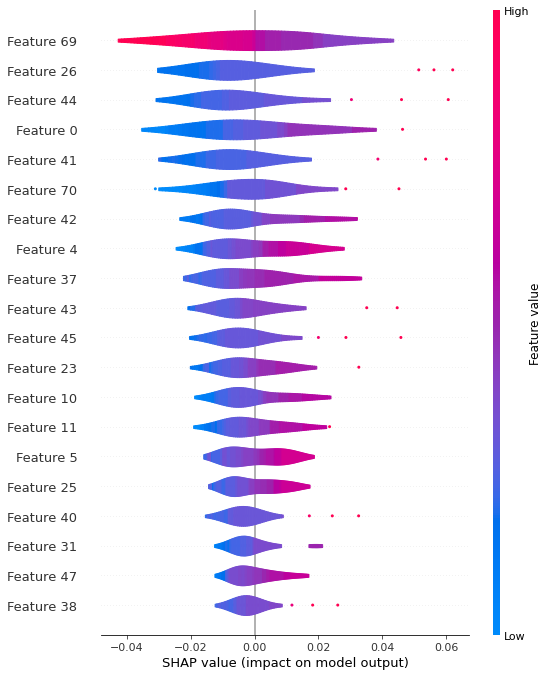

In [24]:
shap.summary_plot(shap_values, scaled_X_test_df,plot_type='violin') #X_test, plot_type='violin') # Top 20 variables

In [ ]:
X_test.columns

Index(['Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'PER_ADVANCED',
       'TS%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'DRB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED',
       'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED', 'OWS_ADVANCED',
       'DWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'OBPM_ADVANCED',
       'DBPM_ADVANCED', 'BPM_ADVANCED', 'VORP_ADVANCED', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 'DRB_TOTAL',
       